In [51]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [52]:
# retriever = AlpacaMarketsRetriever(download_from_gdrive=False, timeframe=config.data_config.frequency)

# retrieval_result = retriever.bars_with_quotes(
#     symbol_or_symbols=config.data_config.symbol_or_symbols, 
#     start=config.data_config.start, 
#     end=config.data_config.end)

# retrieval_result = retriever.bars_with_quotes(
#     symbol_or_symbols=['AAPL', 'XLY'], 
#     start=config.data_config.start, 
#     end=config.data_config.end)

retriever = StooqRetriever(download_from_gdrive=False)
retrieval_result = retriever.bars(start=config.data_config.start)

In [53]:
data_preparer = DataPreparer(
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    missing_values_handler_polars=config.data_config.missing_values_handler_polars,
    in_seq_len=config.data_config.in_seq_len,
    frequency=str(config.data_config.frequency),
    # validator=Validator(),
    raw_features_backend='threading',
    transform_data_for_inference_backend='loky'
)

In [54]:
(X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
    data_preparer.get_experiment_data(
        data=retrieval_result,
        start_date=config.data_config.start,
        end_date=config.data_config.end,
        features=config.data_config.features,
        features_polars=config.data_config.features_polars,
        statistics=config.data_config.statistics,
        target=config.data_config.target,
        train_set_last_date=config.data_config.train_set_last_date,
        val_set_last_date=config.data_config.val_set_last_date,
    )

X_train.shape, y_train.shape, statistics_train['next_return'].shape, \
    X_val.shape, y_val.shape, statistics_val['next_return'].shape, \
    X_test.shape, y_test.shape, statistics_test['next_return'].shape

2025-11-20 19:09:21,896 - INFO - Using monolithic slices with -60 timestamps
2025-11-20 19:09:22,360 - INFO - Found 6891 train slices, 502 val slices, 1258 test slices
2025-11-20 19:09:22,361 - INFO - Trained per-asset targets
2025-11-20 19:09:22,652 - INFO - Time taken to fill missing values with Polars: 0.2898714542388916 seconds
2025-11-20 19:09:22,687 - INFO - Time taken to concatenate lazy frames: 0.03349947929382324 seconds
2025-11-20 19:09:22,939 - INFO - Time taken to generate raw features with Polars: 0.28604578971862793 seconds
2025-11-20 19:09:23,476 - INFO - Time taken to normalize features: 0.5355062484741211 seconds
2025-11-20 19:09:23,641 - INFO - Time taken to generate target features: 0.12959861755371094 seconds
2025-11-20 19:09:23,678 - INFO - Time taken to generate statistics features: 0.03200030326843262 seconds
2025-11-20 19:09:23,729 - INFO - Time taken to generate statistics features: 0.045996665954589844 seconds
2025-11-20 19:09:23,763 - INFO - Time taken to gen

((15199, 30, 80, 16),
 (15199, 30),
 (15199, 30),
 (590, 30, 80, 16),
 (590, 30),
 (590, 30),
 (1686, 30, 80, 16),
 (1686, 30),
 (1686, 30))

In [21]:
# from observability.mlflow_integration import log_experiment


# log_experiment(
#     config=config, 
#     validator_snapshots=data_preparer.validator.snapshots
#     # model=model, 
#     # history=history,
# )

In [22]:
next_return_train, spread_train, volatility_train, \
    next_return_val, spread_val, volatility_val, \
    next_return_test, spread_test, volatility_test = \
        statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
        statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
        statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']

NameError: name 'statistics_train' is not defined

In [8]:
# daily_slices = data_preparer._get_daily_slices(retrieval_result, config.data_config.start, config.data_config.end, 
#     Constants.Data.TRADING_DAY_LENGTH_MINUTES  + data_preparer.in_seq_len + data_preparer.normalizer.window + 30)

# per_asset_target = data_preparer._train_target_per_asset(
#             config.data_config.target,
#             daily_slices,
#             n_timestamps_per_slice=Constants.Data.TRADING_DAY_LENGTH_MINUTES
#         )

# X, y, statistics = data_preparer.transform_data_for_inference( 
#                                       data=daily_slices[1],
#                                       n_timestamps=Constants.Data.TRADING_DAY_LENGTH_MINUTES,
#                                       features=config.data_config.features,
#                                       include_target_and_statistics=True,
#                                       statistics=config.data_config.statistics,
#                                       per_asset_target=per_asset_target,
#                                       n_jobs=os.cpu_count() // 2
#                                       )

In [9]:
# dataset_creator = DatasetCreator(
#     features=config.data_config.features,
#     target=config.data_config.target,
#     normalizer=config.data_config.normalizer,
#     missing_values_handler=config.data_config.missing_values_handler,
#     train_set_last_date=config.data_config.train_set_last_date, 
#     val_set_last_date=config.data_config.val_set_last_date,
#     cutoff_time=config.data_config.cutoff_time,
#     in_seq_len=config.data_config.in_seq_len,
#     multi_asset_prediction=config.data_config.multi_asset_prediction,
# )

# X_train, y_train, next_return_train, spread_train, volatility_train, \
#     X_val, y_val, next_return_val, spread_val, volatility_val, \
#     X_test, y_test, next_return_test, spread_test, volatility_test \
#         = dataset_creator.create_dataset_numpy(retrieval_result)

# X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, \
#     X_val.shape, y_val.shape, next_return_val.shape, spread_val.shape, volatility_val.shape, \
#         X_test.shape, y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape

In [10]:
# 	    next_return, spread, volatility
# train (0.00062720885, 0.00025727754, 0.000789116)
# val   (0.0011397429, 0.0002572774, 0.0014156421)
# test  (0.0005497588, 0.0002572774, 0.00068560627)

In [11]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.04947908, 0.0, 0.011087692)

In [12]:
np.abs(next_return_train).mean(), spread_train.mean(), volatility_train.mean()

(0.04947908, 0.0, 0.011087692)

In [13]:
np.abs(next_return_val).mean(), spread_val.mean(), volatility_val.mean()

(0.041738637, 0.0, 0.0096594365)

In [14]:
np.abs(next_return_test).mean(), spread_test.mean(), volatility_test.mean()

(0.04441642, 0.0, 0.009771811)

In [15]:
train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)
val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
    batch_size=config.train_config.batch_size,
    shuffle=config.train_config.shuffle,
    num_workers=config.train_config.num_workers,
    prefetch_factor=config.train_config.prefetch_factor,
    pin_memory=config.train_config.pin_memory,
    persistent_workers=config.train_config.persistent_workers,
    drop_last=config.train_config.drop_last
)

In [16]:
model = config.model_config.model
model

TimeSeriesTransformer(
  (input_proj): Linear(in_features=16, out_features=64, bias=True)
  (pos_embed): Embedding(80, 64)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
config

ExperimentConfig(data_config=DataConfig(symbol_or_symbols=['AAPL', 'AMD', 'BABA', 'BITU', 'C', 'CSCO', 'DAL', 'DIA', 'GLD', 'GOOG', 'IJR', 'MARA', 'MRVL', 'MU', 'NEE', 'NKE', 'NVDA', 'ON', 'PLTR', 'PYPL', 'QLD', 'QQQ', 'QQQM', 'RKLB', 'RSP', 'SMCI', 'SMH', 'SOXL', 'SOXX', 'SPXL', 'SPY', 'TMF', 'TNA', 'TQQQ', 'TSLA', 'UBER', 'UDOW', 'UPRO', 'VOO', 'WFC', 'XBI', 'XLC', 'XLE', 'XLI', 'XLK', 'XLU', 'XLV', 'XLY', 'XOM', 'XRT'], frequency=<alpaca.data.timeframe.TimeFrame object at 0x00000205FA75C050>, start=datetime.datetime(1970, 1, 2, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), end=datetime.datetime(2019, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), train_set_last_date=datetime.datetime(2012, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), val_set_last_date=datetime.datetime(2014, 1, 1, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), features={'log_ret': <function <lambda> at 0x00000205F9E17420>, 'hl_range': <function <lambda> at 0x000

In [18]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    early_stopping_patience=config.train_config.early_stopping_patience,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

In [19]:
# 0.1154
# 0.3397

In [20]:
model, history = trainer.train()

2025-11-18 16:47:50,119 - INFO - Epoch 1/20
2025-11-18 16:48:25,885 - INFO - Train Loss: 0.1922        
2025-11-18 16:48:25,886 - INFO - Train Rmse: 0.4367
2025-11-18 16:48:25,886 - INFO - Val   Loss: 0.2323
2025-11-18 16:48:25,887 - INFO - Val   Rmse: 0.4816
2025-11-18 16:48:25,887 - INFO - New best model found! Updating best state dict.
2025-11-18 16:48:25,895 - INFO - 
2025-11-18 16:48:25,896 - INFO - Epoch 2/20
2025-11-18 16:48:54,994 - INFO - Train Loss: 0.1793        
2025-11-18 16:48:54,994 - INFO - Train Rmse: 0.4231
2025-11-18 16:48:54,995 - INFO - Val   Loss: 0.2393
2025-11-18 16:48:54,996 - INFO - Val   Rmse: 0.4891
2025-11-18 16:48:54,996 - INFO - 
2025-11-18 16:48:54,996 - INFO - Epoch 3/20
2025-11-18 16:49:30,993 - INFO - Train Loss: 0.1772        
2025-11-18 16:49:30,993 - INFO - Train Rmse: 0.4207
2025-11-18 16:49:30,994 - INFO - Val   Loss: 0.2397
2025-11-18 16:49:30,995 - INFO - Val   Rmse: 0.4896
2025-11-18 16:49:30,995 - INFO - 
2025-11-18 16:49:30,995 - INFO - Epoc

In [21]:
output = torch.tensor([[ 1.2321e-01,  2.5161e-02,  8.5718e-02,  7.0397e-02,  1.7794e-02,
          2.2412e-01, -2.2944e-02,  9.5975e-02,  5.3628e-02,  5.5382e-02,
          1.5277e-01, -1.8584e-02,  3.3734e-02,  7.0550e-02,  1.0624e-01,
          1.0331e-01,  3.0873e-03,  2.7425e-01, -6.2534e-02,  7.7919e-02,
         -9.0598e-03, -9.4928e-02,  1.4311e-01,  1.3758e-01,  5.1702e-01,
          1.4427e-02,  1.4709e-01,  2.7857e-03,  9.6716e-02,  1.1583e-01],
        [ 7.7217e-02,  6.0173e-02, -1.5544e-01,  8.1398e-02, -1.9457e-02,
          5.4479e-03, -5.9562e-02,  2.3583e-01,  2.1842e-01,  4.1519e-01,
         -1.1390e-02,  9.0371e-02,  1.0387e-01,  1.1461e-01, -1.1153e-02,
          1.3507e-01,  1.2309e-02,  1.9418e-01,  4.6356e-02,  7.1493e-02,
         -3.8943e-02,  2.9188e-01,  1.0224e-01, -4.2622e-02,  1.7740e-01,
          7.7241e-02,  2.1203e-01, -6.3874e-02,  1.5434e-01,  3.4010e-02],
        [ 1.9221e-03, -1.7259e-02,  1.4605e-02,  1.1849e-01,  2.1418e-01,
          1.0853e-02, -2.1427e-03, -1.2446e-03,  2.0370e-02,  4.4033e-02,
         -5.1675e-03,  7.5371e-03,  3.6896e-02,  4.5330e-03,  6.4274e-01,
          7.0698e-02, -7.8414e-04, -9.1558e-03,  1.6102e-02,  1.5236e-02,
         -2.0678e-03, -1.4153e-03, -8.3827e-05,  1.2176e-02,  6.4701e-03,
          6.3485e-03,  2.4393e-02, -1.0682e-02, -1.4949e-02, -1.3271e-02],
        [ 7.3544e-02,  1.1644e-01,  2.6032e-01,  8.5851e-02,  4.9058e-02,
          1.6242e-02,  5.6530e-02,  2.3316e-02,  4.0054e-02,  5.4395e-02,
          1.7682e-01,  8.9131e-02,  9.8517e-03,  5.7732e-02,  1.3879e-01,
          4.0316e-02,  1.1061e-01,  5.9927e-02,  9.6030e-03,  6.6498e-02,
          9.0341e-02,  4.5930e-02,  2.7552e-01,  3.4326e-01,  7.6964e-02,
          6.7214e-02,  9.8245e-02, -6.7461e-02,  4.3307e-03,  1.8581e-01],
        [ 2.9868e-01,  3.9093e-01,  4.0409e-02, -9.1478e-03,  2.9124e-01,
          9.5357e-02,  9.9314e-02,  7.3121e-02,  2.0351e-01,  4.4200e-02,
          1.5459e-01,  1.6062e-01,  8.0536e-02,  8.4208e-02,  2.3812e-01,
          1.4715e-02,  1.0639e-01,  3.3153e-02,  1.4891e-01,  1.5995e-01,
          5.0649e-02,  1.0203e-01,  1.9505e-01,  7.0127e-02,  9.2598e-03,
          7.5388e-02,  2.3596e-01,  1.0979e-01,  6.7182e-02,  1.9715e-02],
        [-1.9293e-04,  9.9719e-01,  2.3499e-04,  6.3297e-04,  2.8781e-04,
          7.7846e-04, -6.8274e-05,  1.8202e-04,  7.1475e-04,  1.5354e-03,
         -1.0493e-04, -1.6402e-04,  1.9705e-04,  5.8771e-04,  1.7655e-04,
          6.2852e-04,  5.2141e-04,  1.5765e-03,  6.7855e-04,  5.8350e-04,
          2.5509e-04, -2.1780e-04, -2.1006e-04,  2.6661e-05, -1.6348e-05,
          1.3218e-04, -3.1938e-04, -7.8453e-05,  1.6149e-04,  7.8516e-04],
        [ 3.5260e-02,  6.5059e-02, -1.3199e-03,  9.0311e-02,  5.4382e-02,
          1.0573e-01, -1.1149e-02,  3.1578e-02,  4.4385e-02,  2.4097e-01,
          2.3273e-02,  1.2619e-01,  1.7542e-01,  4.5300e-02,  5.2456e-02,
          3.0908e-02,  1.7689e-01,  4.8554e-02,  3.0559e-02,  4.0904e-02,
          6.1616e-02,  2.2489e-02,  1.5701e-03,  3.7727e-02,  4.6314e-02,
         -1.5135e-02,  6.0699e-02,  1.6863e-02,  4.1604e-02,  9.7465e-02],
        [ 1.1141e-01,  2.9737e-01,  6.2574e-03,  1.0129e-01,  7.9166e-02,
          8.3648e-02,  4.7266e-02,  1.1274e-01,  1.5926e-01,  1.0962e-01,
         -1.1959e-02,  7.1511e-02,  9.3741e-02,  3.0714e-02,  1.2387e-01,
          9.6153e-02,  2.3926e-01,  1.3298e-01,  9.9979e-02,  1.1421e-01,
          7.4017e-02,  1.0371e-01, -1.2090e-02,  6.2906e-02,  2.9999e-01,
          1.0068e-01,  6.9935e-02, -9.5110e-02,  1.1032e-01,  7.3926e-02],
        [-5.4000e-02, -1.8725e-02, -3.6710e-03,  4.7918e-01,  9.6399e-03,
          1.3051e-02,  8.6209e-02, -5.8804e-03,  5.0234e-02,  7.1169e-02,
         -6.5945e-04, -3.0954e-02,  3.5581e-02,  4.0273e-02,  1.9015e-02,
          3.4511e-01,  5.2094e-02,  2.8012e-02,  2.0376e-01,  6.4177e-02,
          8.2194e-03, -1.1038e-02,  1.0216e-02,  5.5483e-02, -1.0458e-02,
         -3.5577e-03,  3.9147e-03,  2.8381e-02,  3.8482e-02,  9.7195e-02],
        [-2.5521e-04,  1.2265e-04, -1.8794e-04, -7.9868e-05,  4.5951e-04,
          2.6379e-04, -3.1986e-04, -2.8450e-04,  5.2176e-05,  1.8999e-04,
          1.8345e-05, -1.6688e-04,  1.8884e-04,  3.6148e-04,  4.2620e-01,
          4.9089e-04,  3.1728e-04,  1.3115e-04,  3.3760e-04,  1.0885e-03,
         -8.1888e-06, -1.3742e-04,  7.2304e-05,  8.4731e-05, -7.9021e-05,
          9.6316e-05, -2.3336e-05, -3.1636e-04, -3.6366e-05,  5.7325e-01],
        [ 1.0248e-01,  2.7491e-02, -8.5003e-03,  8.1741e-02,  1.5681e-02,
          2.5876e-02,  5.9958e-02,  8.1144e-02,  9.1651e-02,  6.7228e-02,
         -1.8721e-02,  4.4345e-02,  8.7524e-02,  6.4118e-02,  2.7549e-01,
          8.6539e-02,  2.7482e-01,  1.7391e-01,  2.6030e-02,  4.5713e-02,
          1.0058e-01,  1.4459e-01,  7.6153e-03,  4.6508e-02,  5.2280e-02,
          4.7718e-02,  7.3945e-02, -2.2828e-02, -2.5079e-03,  1.1514e-01],
        [ 8.2802e-02,  4.0636e-01, -3.9215e-02,  1.2439e-01,  1.9953e-01,
          1.9860e-01,  1.1300e-01,  8.7933e-02,  1.0501e-01,  2.1309e-01,
          1.4785e-01,  2.9534e-01, -9.2975e-03,  2.1178e-01,  2.2762e-03,
          5.9422e-02,  1.1157e-01, -3.3381e-02,  1.2882e-01,  3.6742e-01,
         -1.2621e-02,  1.3934e-01,  2.2336e-01,  1.0146e-01,  6.5516e-03,
          2.5080e-01,  1.2826e-01,  1.6891e-01, -4.7370e-02,  7.6253e-02],
        [ 2.4012e-05, -1.7590e-04, -1.9352e-04,  5.0660e-01,  3.2582e-04,
          5.5429e-04,  1.8281e-05, -8.0119e-05,  6.2736e-04,  1.2934e-03,
         -8.5598e-05,  1.3419e-04,  4.4168e-01,  4.6162e-04,  1.6898e-04,
          3.4814e-04,  7.8199e-06,  4.7514e-02,  2.0727e-04,  3.9548e-03,
          9.9728e-05, -6.1899e-05, -9.2974e-06,  3.0694e-04, -8.0375e-05,
          5.0281e-06, -1.7881e-04, -1.5257e-05, -1.5398e-04,  1.2952e-03],
        [ 2.5001e-03,  4.4923e-04,  5.8148e-04,  3.3544e-03,  2.2739e-03,
          2.5198e-03,  2.3427e-03,  1.1397e-04,  2.6658e-03,  1.8278e-03,
          1.0886e-03, -5.4260e-04,  1.9030e-03,  2.3371e-03,  9.4852e-04,
          1.0138e-03,  2.1097e-03,  2.5953e-03,  7.6479e-04,  2.3815e-03,
          2.8709e-03,  3.4825e-03,  5.6365e-04,  5.7036e-04,  3.2862e-03,
          9.8771e-01,  3.4340e-03,  6.0681e-04,  1.8903e-03,  4.2378e-04],
        [ 1.7361e-01,  5.0796e-02,  2.0921e-01,  1.8533e-02,  1.4787e-01,
          1.4493e-02, -4.6749e-02,  2.2291e-01,  1.4763e-01,  1.5918e-01,
          6.1765e-02,  9.1016e-02, -2.7006e-04,  8.5613e-02,  2.5096e-01,
          1.3134e-01,  1.1376e-02,  1.6401e-01,  1.2528e-01,  1.2271e-01,
         -2.0983e-03,  8.0472e-02, -4.5197e-02,  2.7611e-01,  1.4440e-01,
          9.4782e-02,  3.4747e-01, -1.3184e-01,  2.2752e-01,  8.1022e-02],
        [-4.2147e-05, -3.7418e-05,  1.2774e-04,  6.5870e-04,  3.7068e-04,
          5.0437e-04, -2.6824e-04,  2.4017e-04,  5.3623e-04,  1.8500e-04,
         -3.1512e-07, -1.0464e-04,  2.2648e-04,  4.1481e-04,  5.0096e-01,
          1.0282e-03,  1.5042e-04,  7.2058e-04,  3.8662e-04,  1.5774e-03,
         -6.6278e-05,  1.0554e-04, -3.2892e-06,  5.5388e-04, -3.2856e-05,
          3.9548e-04,  3.5775e-04,  2.0843e-04, -5.6967e-05,  4.9590e-01]],
       device='cuda:0')

target = torch.tensor([[ 7.8536e-02, -2.6706e-02,  5.8316e-02,  3.0690e-02,  1.6870e-03,
          1.0987e-01,  0.0000e+00, -8.5504e-03,  9.2898e-02,  2.6571e-02,
          5.3058e-02,  6.4274e-02,  2.1190e-02,  2.9680e-02, -1.3670e-02,
          2.7523e-02, -9.7080e-02,  3.4858e-02, -3.8291e-02, -2.5218e-01,
          3.1408e-02,  4.9971e-02,  1.9150e-01, -2.7409e-02,  9.2909e-02,
          0.0000e+00,  1.0605e-01,  0.0000e+00,  1.3703e-02,  9.4790e-03],
        [ 4.8534e-02,  1.1487e-01,  0.0000e+00, -5.5950e-03,  1.1629e-01,
         -4.7349e-02,  0.0000e+00,  1.1085e-01,  2.5107e-02, -3.4215e-02,
          0.0000e+00,  4.7163e-02,  3.6258e-02,  2.1711e-02, -2.6599e-02,
         -4.4802e-03,  2.5422e-02, -1.8559e-02, -5.3283e-03,  2.8641e-02,
          0.0000e+00,  1.0262e-01,  0.0000e+00,  1.3891e-02,  1.4530e-02,
          0.0000e+00, -7.2589e-02,  0.0000e+00,  2.9019e-02,  2.2078e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.7236e-02, -3.7983e-02,
         -3.5901e-03,  0.0000e+00,  0.0000e+00, -8.1178e-03,  4.3936e-02,
          0.0000e+00,  0.0000e+00, -4.9803e-02,  1.0864e-02,  9.0044e-02,
          0.0000e+00,  3.5202e-02,  7.5845e-02,  2.4103e-02,  2.2053e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  5.9047e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.7908e-01, -1.2494e-01,  1.2095e-01,  3.7099e-02,  6.3935e-02,
          6.4567e-02,  1.5955e-01, -2.9488e-02,  4.5657e-02, -1.2883e-02,
          5.1088e-02,  1.1935e-02,  5.9374e-02,  4.2342e-02, -1.6524e-02,
         -1.2345e-02,  1.6164e-03,  1.8558e-02,  4.7529e-02,  1.7697e-02,
         -7.4810e-04,  6.0021e-02,  6.1825e-02,  1.7822e-02,  4.5200e-02,
         -4.0822e-04,  2.6410e-02,  0.0000e+00,  8.6244e-02,  2.4623e-02],
        [-3.6586e-01, -2.3362e-01, -2.9254e-01, -4.0273e-01, -3.3195e-01,
         -3.3449e-01, -4.3862e-01, -2.5234e-01, -3.0158e-01, -3.0048e-01,
         -4.3441e-01, -3.3047e-01, -3.5749e-01, -2.6382e-01, -2.1512e-01,
         -2.6310e-04, -2.3356e-01, -1.7360e-01, -2.2427e-01, -2.2818e-01,
         -2.1360e-01, -1.0573e-01, -3.3875e-01, -1.8495e-01, -1.6875e-01,
         -3.1625e-01, -4.2087e-01, -2.6705e-01, -2.2915e-01, -1.9345e-01],
        [-1.4790e-01,  0.0000e+00,  0.0000e+00, -8.0934e-02,  3.8912e-02,
         -2.5978e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9880e-03,
          0.0000e+00, -1.3344e-01, -4.7130e-02,  1.9112e-02, -6.1770e-02,
         -8.8098e-02, -2.9017e-02, -3.4796e-02,  1.6108e-03, -2.1953e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -8.4838e-03,  2.8194e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -6.1991e-02, -2.7543e-02],
        [ 2.5061e-01,  6.4628e-02,  0.0000e+00,  2.8424e-02,  1.1505e-02,
          9.9533e-02,  0.0000e+00,  9.8809e-02,  9.3407e-02,  3.4048e-02,
          0.0000e+00,  8.6340e-02,  1.4172e-02,  9.3636e-02,  6.4498e-02,
          6.7854e-02,  3.8522e-02,  8.0958e-02, -6.4358e-03,  1.0975e-02,
          1.0489e-01,  3.6768e-02,  0.0000e+00,  7.7603e-02,  5.9633e-02,
          0.0000e+00, -3.0924e-03,  0.0000e+00, -3.5025e-03,  2.1381e-02],
        [-2.8916e-01, -1.4940e-02,  0.0000e+00, -1.4241e-01, -3.5614e-02,
          7.7100e-02,  0.0000e+00,  2.2219e-01,  3.2603e-02,  8.6367e-03,
          0.0000e+00,  5.9154e-02,  3.4864e-02, -8.2101e-02, -3.4221e-02,
          2.7426e-02,  1.8678e-02, -4.3120e-02, -1.2549e-02,  8.3713e-02,
         -7.9335e-02,  3.6352e-02,  0.0000e+00, -2.6569e-02, -1.6226e-02,
          0.0000e+00,  1.1128e-01,  0.0000e+00, -3.7264e-02, -5.0220e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0283e-01, -1.0149e-01,
         -1.1957e-01,  0.0000e+00,  0.0000e+00, -1.0682e-01, -2.5508e-01,
          0.0000e+00,  0.0000e+00, -2.5352e-01, -8.3545e-02, -6.5665e-02,
         -1.5694e-02, -3.2446e-01, -2.1584e-01, -1.4338e-01, -1.4388e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2686e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.2501e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -8.1418e-02,
          2.0089e-03,  0.0000e+00,  0.0000e+00,  5.9284e-02, -4.4255e-02,
          0.0000e+00,  0.0000e+00,  1.1840e-01,  1.2613e-02, -1.0829e-02,
          1.2535e-02, -7.1868e-02, -3.7503e-02, -3.5648e-02,  8.9840e-03,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -3.4931e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.5152e-01,  5.2244e-02,  0.0000e+00,  1.0438e-01,  1.0950e-01,
          1.1491e-01,  0.0000e+00,  5.5377e-02,  6.1549e-02,  8.9581e-02,
          0.0000e+00,  1.8636e-01,  9.7347e-02,  0.0000e+00,  5.5591e-02,
          6.9004e-02,  5.9685e-02,  6.0660e-02,  1.5315e-01, -2.0856e-02,
         -1.0368e-01,  7.5419e-02,  0.0000e+00,  5.6701e-02,  1.0978e-01,
          0.0000e+00,  6.6532e-02,  0.0000e+00, -5.8394e-03,  1.3108e-01],
        [ 1.0907e-01,  5.6037e-02,  1.0646e-01,  1.4052e-01,  4.8926e-02,
          1.4751e-01,  9.1796e-02,  4.0673e-02,  1.0291e-01,  7.8432e-02,
          4.5765e-02,  7.9532e-02,  7.9860e-02,  1.7093e-02,  1.5137e-02,
          1.0576e-01,  1.0350e-02,  4.6782e-02,  4.0880e-02, -5.0081e-02,
          5.1022e-02,  7.4850e-02,  1.4525e-02, -8.4034e-03,  1.2941e-01,
          5.9602e-04, -7.3229e-02,  3.0575e-02, -1.3001e-02, -3.3245e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5854e-01,  1.5210e-01,
          1.0787e-01,  0.0000e+00,  0.0000e+00,  3.9267e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  9.4231e-02, -2.8206e-02,  2.2427e-02,
         -1.0736e-01, -1.7737e-02,  1.0304e-01, -3.7868e-02,  4.4077e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2568e-01,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-9.8461e-02, -6.1040e-02,  5.0785e-02, -5.4558e-03,  2.0509e-02,
          1.0739e-01,  1.7586e-01, -5.0532e-02,  2.6139e-02, -1.3062e-02,
          1.5835e-02,  4.0354e-02,  4.3489e-02, -1.4049e-03, -1.1897e-02,
          7.1498e-02, -1.3730e-02,  1.8167e-02, -3.1725e-02, -1.6485e-02,
         -5.8057e-02,  5.6221e-02, -4.7570e-02, -1.8119e-03,  7.9315e-02,
          3.7559e-02, -6.2804e-02,  0.0000e+00,  3.4714e-02, -2.2211e-03],
        [-5.8868e-02,  3.6823e-02,  0.0000e+00,  1.0098e-01,  2.6916e-02,
         -1.3350e-02,  0.0000e+00,  1.7047e-02,  3.9597e-02,  4.2609e-02,
          0.0000e+00,  2.8891e-02,  1.3889e-02,  9.8790e-02,  4.8216e-02,
          9.2749e-02,  2.5243e-02, -1.9922e-02, -5.6873e-02,  5.4001e-02,
          1.1415e-02,  9.1380e-02,  0.0000e+00, -5.3924e-03,  0.0000e+00,
          0.0000e+00,  1.1724e-02,  0.0000e+00,  1.3119e-02, -5.1321e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.4476e-02, -6.9969e-03,
          1.8354e-02,  0.0000e+00,  0.0000e+00,  4.7889e-02, -1.4529e-02,
          0.0000e+00,  0.0000e+00,  5.3555e-02,  3.7101e-02,  1.0414e-02,
          0.0000e+00, -4.5391e-02,  1.8864e-02, -1.4938e-02,  5.8045e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1711e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       device='cuda:0')
from modeling.loss import PositionReturnLoss, position_return_loss_with_entropy

PositionReturnLoss(fee=0.001)(output[4], target[4])

tensor(nan, device='cuda:0')

In [21]:
sum(output[9])

NameError: name 'output' is not defined

In [ ]:
target[4]

tensor([-3.6586e-01, -2.3362e-01, -2.9254e-01, -4.0273e-01, -3.3195e-01,
        -3.3449e-01, -4.3862e-01, -2.5234e-01, -3.0158e-01, -3.0048e-01,
        -4.3441e-01, -3.3047e-01, -3.5749e-01, -2.6382e-01, -2.1512e-01,
        -2.6310e-04, -2.3356e-01, -1.7360e-01, -2.2427e-01, -2.2818e-01,
        -2.1360e-01, -1.0573e-01, -3.3875e-01, -1.8495e-01, -1.6875e-01,
        -3.1625e-01, -4.2087e-01, -2.6705e-01, -2.2915e-01, -1.9345e-01],
       device='cuda:0')

In [22]:
torch.log1p(torch.tensor(-1.0718))

tensor(nan)

In [23]:
trajectory_length = 12
horizon = 30
train_trajectory_loader = TrajectoryDataset(X_train, next_return_train, spread_train, volatility_train, \
        trajectory_length=trajectory_length, horizon=horizon, shift_data_within_horizon=True).as_dataloader(
    batch_size=8, 
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
val_trajectory_loader = TrajectoryDataset(X_val, next_return_val, spread_val, volatility_val, \
        trajectory_length=trajectory_length, horizon=horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)
test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
        trajectory_length=trajectory_length, horizon=horizon).as_dataloader(
    batch_size=1, 
    shuffle=False,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True,
    persistent_workers=True,
    drop_last=False,
)

In [24]:
env = PortfolioEnvironment(
    reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
)

actor = RlActor(
    model,
    n_assets=len(retrieval_result),
    train_signal_predictor=False,
).to(device)

signal_predictor_actor = SignalPredictorActor(
    model, 
    trade_asset_count=1,
    train_signal_predictor=False
).to(device)

allocation_propogation_actor = AllocationPropogationActor(
    model, 
    train_allocator=False
).to(device)

market_actor = MarketActor().to(device)

rl_agent = RlAgent(
    actor, 
    env
)

metrics_calculator = MetricsCalculator(
    metrics=DEFAULT_METRICS
)

policy_gradient = PolicyGradient(
    rl_agent, 
    train_trajectory_loader, 
    val_trajectory_loader, 
    metrics_calculator=metrics_calculator,
    optimizer=torch.optim.AdamW(
        [p for p in actor.parameters() if p.requires_grad], 
        lr=1e-3,
        weight_decay=1e-5,
        amsgrad=True),
    scheduler=None,
    loss_fn=ReinforceLoss(use_baseline=False),
    num_epochs=10,
    device=device
)

In [25]:
# policy_gradient.train()

In [26]:
print('Val set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor)

Val set evaluation


c:\Users\ikurnosau\Projects\QuantitativeTrading\intraday-portfolio-management\modeling\rl\metrics.py:46: RuntimeWarning: overflow encountered in power
  return float((np.prod(1.0 + r) ** (1.0 / years)) - 1.0)
2025-11-18 17:13:19,072 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 0.4794, MeanReturnPercentage: 2.1391, ARR: inf, AVOL: 17.8582, MDD: -0.1811, ASR: inf, CR: inf, DDR: inf, SoR: 0.3547


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


In [27]:
print('Test set evaluation')
epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor, test_trajectory_loader)

Test set evaluation


2025-11-18 17:13:26,401 - INFO - [PolicyGradient] [VAL] Epoch 0/10 — CumulativeReturn: 1.3499, MeanReturnPercentage: 1.6521, ARR: inf, AVOL: 17.2542, MDD: -0.1669, ASR: inf, CR: inf, DDR: inf, SoR: 0.5340


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


In [30]:
a = next(iter(test_trajectory_loader))
a[0].shape

torch.Size([1, 12, 30, 80, 16])

In [31]:
from modeling.rl.state import State
state = State(a[0][0].to(policy_gradient.device), None, None, None, None)
result = model.forward(a[0][0].to(policy_gradient.device))
result[0].shape

torch.Size([30])

In [32]:
result[0].sum()

tensor(19.0582, device='cuda:0')

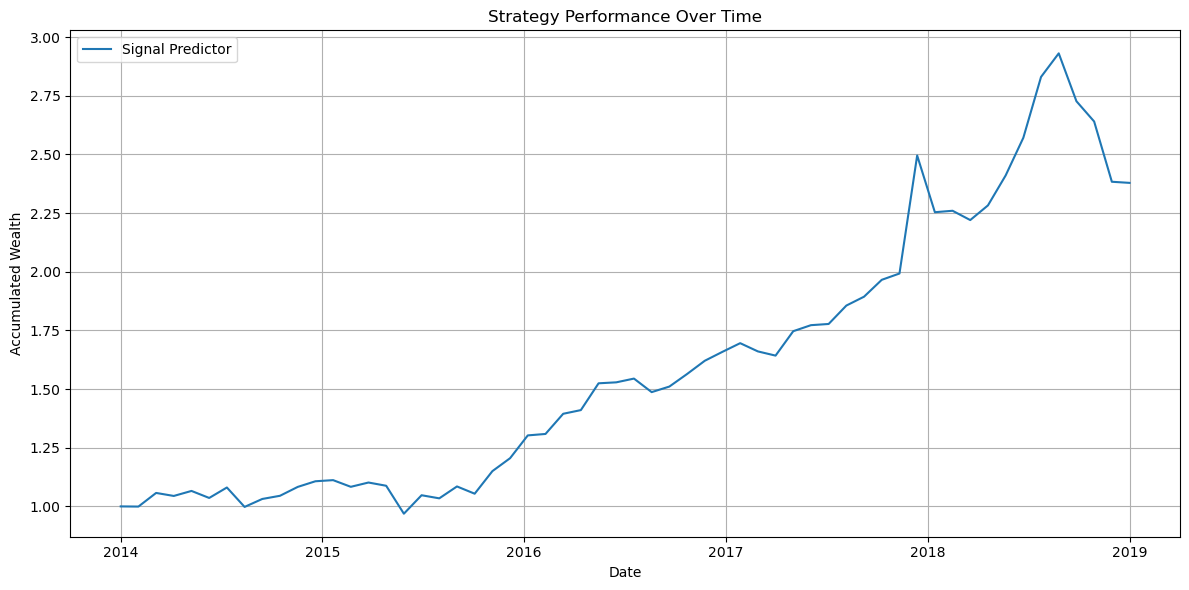

In [33]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns_signal_predictor,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end
)

In [ ]:
sum(actions_signal_predictor[0])

In [ ]:
actions_signal_predictor[0]

In [ ]:
plot_position_heatmap(actions_signal_predictor, asset_names=sorted(list(retrieval_result.keys())))

In [ ]:
import copy  # Local import to avoid polluting global namespace unnecessarily
state_dict = (
    model.module.state_dict()
        if isinstance(model, torch.nn.DataParallel)
    else model.state_dict()
)

# Keep a local copy of the best weights so we can return the best model
# after training finishes, without needing to reload from disk.
best_model_state = copy.deepcopy(state_dict)

# Persist to disk if a save_path was provided
torch.save(state_dict, "best_model.pth")